In [1]:
#Part 1 Setup Code 
#begin by importing packages needed
import pandas as pd
import os
import numpy as np
from os import sep
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
#set current working directory path
os.chdir("C:\\Users\\ltswe\\Dropbox\\Oxford\\Michaelmas Term Classes\\Applied Analytical Statistics") 
cwd = os.getcwd()

In [3]:
#set up folders 
if not os.path.exists('stats_summative'):
    os.makedirs('stats_summative')

if not os.path.exists(f'stats_summative{sep}data'):
    os.makedirs(f'stats_summative{sep}data')

In [4]:
#download data from the Internet; unzip any that is currently in gz form
import gzip
import urllib
import requests

def dataframe_upload(url, name, gz=False):
    ''' 
    Given a URL and string name, this function downloads data from the Internet, unzips it to a file entitled 'name' if it's a
    gzip file (when gzip=True), and returns a dataframe corresponding to that file
    '''
    r = requests.get(url)
    with open(f'{cwd}{sep}stats_summative{sep}data{sep}' + name, 'wb') as f:
         f.write(r.content)
    if gz == True:
        with gzip.open(f'{cwd}{sep}stats_summative{sep}data{sep}' + name) as f:
            df = pd.read_csv(f)
    else:
        df = pd.read_csv(f'{cwd}{sep}stats_summative{sep}data{sep}' + name)
    return df


In [5]:
# Create a function that uses the Socrata API, which is written in SoQL, a SQL-like language, to query data
from sodapy import Socrata

def socrata_API_df(source_domain, dataset_id, select_string, where_string, limit=1000):
    '''
    Inputs: 
    source_domain: This tells Socrata the source of the dataset you're querying
    dataset_id: This is the unique id of the dataset
    select_string: This string tells Socrata which variables you are selecting from the dataset
    where_string: This string is equivalent to the "where" command in SQL
    limit = This tells Socrata how many results to query. The default is 1000 b/c Socrata automatically sets it to 1000

    Outputs a dataframe with with the queried results
    '''
    keyFile = open(f'{cwd}{sep}stats_summative{sep}apikey.txt', 'r')
    token = keyFile.readline() #api token imported from txt file
    
    client = Socrata(source_domain, token)
    # Change timeout var to arbitrarily large # of seconds so it doesn't time out
    client.timeout = 50
    results = client.get(dataset_id, limit = limit, select = select_string, where = where_string)
    df = pd.DataFrame.from_records(results)
    return df


In [6]:
nyc_311 = socrata_API_df(source_domain = "data.cityofnewyork.us", dataset_id = "erm2-nwe9", \
                         select_string = 'unique_key, created_date, complaint_type, date_extract_y(created_date) as year, date_extract_m(created_date) as month, descriptor, incident_address, latitude, longitude', \
                         where_string = 'latitude IS NOT NULL AND ((year = 2016 AND (month = 6 OR month = 7 OR month = 8 OR month = 9 OR month = 10 OR month = 11 OR month = 12)) OR (year = 2017 AND (month = 1 OR month = 2 OR month = 3 OR month = 4))) AND (complaint_type = "Noise - Residential" OR complaint_type = "Illegal Parking" OR complaint_type = "Rodent")', \
                         limit = 1000000)


nyc_null = socrata_API_df(source_domain = "data.cityofnewyork.us", dataset_id = "erm2-nwe9", \
                         select_string = 'unique_key, created_date, complaint_type, date_extract_y(created_date) as year, date_extract_m(created_date) as month, descriptor, incident_address, latitude, longitude',
                         where_string = 'latitude IS NULL AND ((year = 2016 AND (month = 6 OR month = 7 OR month = 8 OR month = 9 OR month = 10 OR month = 11 OR month = 12)) OR (year = 2017 AND (month = 1 OR month = 2 OR month = 3 OR month = 4))) AND (complaint_type = "Noise - Residential" OR complaint_type = "Illegal Parking" OR complaint_type = "Rodent")', \
                          limit = 10000)

print(nyc_null.complaint_type.value_counts(), "\n \n")
print(nyc_311.complaint_type.value_counts())

# Cut lat/long to 3 decimals (100 m)
def round_lat_long(df):
    df["latitude"] = df["latitude"].apply(lambda x: round(float(x),3))
    df["longitude"]= df["longitude"].apply(lambda x: round(float(x),3))

round_lat_long(nyc_311)

# Rename vars to be consistent across cities
ny_311_recode_dict = {"Noise - Residential": "Noise", "Illegal Parking": "Parking", "Rodent": "Infestation"}
nyc_311["complaint_type"] = nyc_311["complaint_type"].map(ny_311_recode_dict)



Illegal Parking        1845
Noise - Residential     629
Rodent                  185
Name: complaint_type, dtype: int64 
 

Noise - Residential    203065
Illegal Parking        117161
Rodent                  29771
Name: complaint_type, dtype: int64


In [7]:
# Use API to access data from SF 311
# Get rid of null lat/long (where lat/long = 0); get rid of obs where case is "invalid" or a "duplicate"
sf_311 = socrata_API_df(source_domain = "data.sfgov.org", dataset_id = "vw6y-z8j6", \
              select_string = 'requested_datetime AS date, date_extract_y(date) as year, date_extract_m(date) as month, status_notes AS status, service_name, service_subtype, lat as latitude, long as longitude', \
              where_string = 'lat > 0 AND ((year = 2017 AND (month = 8 OR month = 9 OR month = 10 OR month = 11 OR month =12)) OR (year = 2018 AND (month = 1 OR month = 2 OR month = 3 OR month = 4 OR month = 5 OR month = 6))) AND (service_name = "Parking Enforcement" OR service_subtype = "Building - Infestation_Rodent_Insect" OR service_subtype = "vehicle_car_alarm" OR service_subtype = "other_excessive_noise" OR service_subtype = "amplified_sound_electronics" OR service_subtype = "Noise Issue") AND status NOT LIKE "Case is a Duplicate%" AND status NOT LIKE "Case is Invalid%"', \
                       limit = 50000)

# Check to ensure data with null lat/long doesn't make up too much of the data
sf_null = socrata_API_df(source_domain = "data.sfgov.org", dataset_id = "vw6y-z8j6", \
              select_string = 'requested_datetime AS date, date_extract_y(date) as year, date_extract_m(date) as month, status_notes AS status, service_name, service_subtype, lat as latitude, long as longitude', \
              where_string = '(lat = 0 OR long = 0) AND ((year = 2017 AND (month = 8 OR month = 9 OR month = 10 OR month = 11 OR month =12)) OR (year = 2018 AND (month = 1 OR month = 2 OR month = 3 OR month = 4 OR month = 5 OR month = 6))) AND (service_name = "Parking Enforcement" OR service_subtype = "Building - Infestation_Rodent_Insect" OR service_subtype = "vehicle_car_alarm" OR service_subtype = "other_excessive_noise" OR service_subtype = "amplified_sound_electronics" OR service_subtype = "Noise Issue") AND status NOT LIKE "Case is a Duplicate%" AND status NOT LIKE "Case is Invalid%"', \
                       limit = 1000)

print("Null\n", sf_null.service_name.value_counts(), "\n \n")
print("Non-null\n", sf_311.service_name.value_counts())

round_lat_long(sf_311)

# Rename "Residential Building Request" to "Rodent/Insect" (it's the only type of Res building request I pulled)
sf_311_recode_dict = {"Parking Enforcement": "Parking", "Noise Report": "Noise", "Residential Building Request": "Infestation"}
sf_311["complaint_type"] = sf_311["service_name"].map(sf_311_recode_dict)


Null
 Noise Report                    99
Residential Building Request    46
Parking Enforcement             31
Name: service_name, dtype: int64 
 

Non-null
 Parking Enforcement             10733
Noise Report                     1100
Residential Building Request      266
Name: service_name, dtype: int64


In [8]:
# Download Boston data. 
#2018
boston_311_18 = dataframe_upload("https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/311_service_requests_2018.csv", \
                                'boston_311_18')
#extract month
boston_311_18['month'] = boston_311_18['open_dt'].apply(lambda x: int(x[5:7]))
#drop unnecessary months
boston_311_18 = boston_311_18[(boston_311_18["month"] == 9) | (boston_311_18["month"] == 10) | \
                              (boston_311_18["month"] == 11) | (boston_311_18["month"] == 12) ]

#2019
boston_311_19 = dataframe_upload("https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/311_service_requests_2019.csv", \
                                'boston_311_19')
#extract month. No need to drop months as we use all of 2019.
boston_311_19['month'] = boston_311_19['open_dt'].apply(lambda x: int(x[5:7]))


#2020
boston_311_20 = dataframe_upload("https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/script_105774672_20210108153400_combine.csv", \
                                'boston_311_20')
#extract months
boston_311_20['month'] = boston_311_20['open_dt'].apply(lambda x: int(x[5:7]))
#drop unnecessary months
boston_311_20 = boston_311_20[(boston_311_20["month"] == 1) | (boston_311_20["month"] == 2)]

# Append and drop unnecessary 311 calls
boston_311_raw = boston_311_18.append(boston_311_19.append(boston_311_20))
boston_311 = boston_311_raw[(boston_311_raw['reason'] == "Generic Noise Disturbance") |  (boston_311_raw['reason'] == "Parking Complaints") | \
                           (boston_311_raw['case_title'] == "Mice Infestation - Residential")]

# Extract the year (for later use)
boston_311['year'] = boston_311['open_dt'].apply(lambda x: int(x[0:4]))

round_lat_long(boston_311)

# Recode complaints to match other two cities
boston_311_recode_dict = {"Parking Complaints": "Parking", "Generic Noise Disturbance": "Noise", "Housing": "Infestation"}
boston_311["complaint_type"] = boston_311["reason"].map(boston_311_recode_dict)


<ipython-input-8-25efadf56159>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_311['year'] = boston_311['open_dt'].apply(lambda x: int(x[0:4]))
<ipython-input-6-49475078360f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["latitude"] = df["latitude"].apply(lambda x: round(float(x),3))
<ipython-input-6-49475078360f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [9]:
#download Airbnb data
#NYC: January 2016 to December 2017; Boston: 
nyc_dates = ["2016-06-02", "2016-07-02", "2016-08-02", "2016-09-02", "2016-10-01", "2016-11-02", \
            "2016-12-03", "2017-01-01", "2017-02-02", "2017-03-02", "2017-04-02"]
boston_dates = ["2018-09-14", "2018-10-11", "2018-11-17", "2018-12-13", "2019-01-17", "2019-02-09", "2019-03-12", "2019-04-15", "2019-05-19", "2019-06-14", \
               "2019-07-14", "2019-08-19", "2019-09-22", "2019-10-18", "2019-11-21", "2019-12-04", "2020-01-05", "2020-02-13"]
sf_dates = ["2017-08-02", "2017-09-02", "2017-10-02", "2017-11-01", "2017-12-02", "2018-01-10", "2018-02-02", "2018-03-04", \
            "2018-04-06", "2018-05-09", "2018-07-05"]
def download_airbnb(city, dates):
    city_listings = pd.DataFrame()
    for date in dates:
        df = dataframe_upload("http://data.insideairbnb.com/united-states/" + city + date + "/data/listings.csv.gz", date+ "listings", gz=True)
        df["date"] = date
        city_listings = city_listings.append(df)
    return city_listings
    
# Download data and round lat/long to 3 digits
nyc_listings = download_airbnb("ny/new-york-city/", nyc_dates)
round_lat_long(nyc_listings)
boston_listings = download_airbnb("ma/boston/", boston_dates)
round_lat_long(boston_listings)
sf_listings = download_airbnb("ca/san-francisco/", sf_dates)
round_lat_long(sf_listings)

C:\Users\ltswe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (43,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\ltswe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\ltswe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
nyc_listings["property_type"].unique()

array(['House', 'Apartment', 'Condominium', 'Bed & Breakfast', 'Dorm',
       'Townhouse', 'Boat', 'Bungalow', 'Loft', 'Other', 'Tent', 'Cabin',
       nan, 'Villa', 'Earth House', 'Camper/RV', 'Castle', 'Hut',
       'Chalet', 'Igloo', 'Entire Floor', 'Cave', 'Guesthouse',
       'Lighthouse', 'Train', 'Tipi', 'Island', 'Timeshare',
       'Boutique hotel', 'Serviced apartment', 'Hostel'], dtype=object)

In [33]:
# Collapse variables by month/year and lat/long
def format_collapse_listings(df):
    '''
    This function first reformats/prepares the listings database for collapsing, 
    then collapses the variables needed for summary & regression for each city by month, year, latitude and longitude 
    Input: df = city listings dataframe (nyc_listings, boston_listings, etc.)
    Output: outputs a dataframe with the collapsed data
    '''
    
    #Extract year/month from date
    df["year"] = df["date"].apply(lambda x: int(x[0:4]))
    df["month"] = df["date"].apply(lambda x: int(x[5:7]))
    
    # Recode "Room Type" string to int
    room_type_recode = {"Entire home/apt": 1, "Shared room": 0, "Private room": 0 }
    df["room_type_recoded"] = df["room_type"].map(room_type_recode)
    
    # Recode host_is_superhost
    superhost_recode = {'f': 0, 't': 1}
    df['host_is_superhost_recoded'] = df['host_is_superhost'].map(superhost_recode)
    # Replace NA with 0
    df['host_is_superhost_recoded'] = df['host_is_superhost_recoded'].fillna(0)
    
    # Host number of listings -> = 1 if greater than 1, 0 else
    def recode_host_tot_listings(num):
        if num == 1:
            return 0
        else:
            return 1
    # recode host tot number of listings
    df['host_multi_listings_flag'] = df['host_total_listings_count'].apply(recode_host_tot_listings)
    
    # Delete any properties that appear to be hotels (which sometimes advertise on Airbnb)
    df = df[(df.property_type != 'Bed & Breakfast') & (df.property_type != 'Cave') & (df.property_type != 'Boutique hotel') \
           & (df.property_type != 'Hostel') & (df.property_type != 'Timeshare') & (df.property_type != 'Hotel')\
          & (df.property_type != 'Bed and breakfast') & (df.property_type != 'Aparthotel') & (df.property_type != 'Resort')] 
    
    # Create var = number of airbnb units able to be booked in next 30 days
    df["#_booked_30"] = df["availability_30"].apply(lambda x: 30-x)

    # Collapse room_type avg, host_is_superhost avg, host_total_listings_count avg, id count (listings), 
    # bookings count by latitude/longitude and year/month
    collapsed_df = df.groupby(["month", "year", "latitude", "longitude"]).agg({"id": "count", "#_booked_30": "sum", \
                                                                               "room_type_recoded": "sum", \
                                                                              "host_is_superhost_recoded": "sum", \
                                                                              "host_multi_listings_flag": "sum"})
    collapsed_df.reset_index(inplace=True)
    return collapsed_df
    
def collapse_city_311(df, id_var):
    '''
    This function first collapses the  
    then collapses the variables needed for summary & regression for each city by month, year, latitude, longitude and type of complaint
    Input: df = city 311 dataframe (nyc_311, boston_311, etc.)
    id_var = name of the id variable (unique_key for nyc, etc.). We'll be collapsing this.
    Output: outputs a dataframe with the collapsed data
    '''
        
    collapsed_city = df.groupby(["month", "year", "latitude", "longitude", "complaint_type"]).agg({id_var: "count"})
    collapsed_city.reset_index(inplace=True)
    # Make month and year into integers for merging purposes -- they're currently strings
    collapsed_city["month"] = collapsed_city["month"].apply(lambda x: int(x))
    collapsed_city["year"] =collapsed_city["year"].apply(lambda x: int(x))
    collapsed_city.rename(columns={id_var: "#_complaints"}, inplace=True)
    return collapsed_city

# Commence the collapsing
collapsed_nyc_listings = format_collapse_listings(nyc_listings)
collapsed_boston_listings = format_collapse_listings(boston_listings)
collapsed_sf_listings = format_collapse_listings(sf_listings)

# Collapse 311 data
collapsed_nyc_311 = collapse_city_311(nyc_311, "unique_key")
collapsed_sf_311 = collapse_city_311(sf_311, "date")
collapsed_boston_311 = collapse_city_311(boston_311, "case_enquiry_id")


<ipython-input-33-c630a8e81250>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["#_booked_30"] = df["availability_30"].apply(lambda x: 30-x)


KeyError: '#_booked_30'

In [39]:
#Merge collapsed city listings and 311 data 
def merge_city_data(city_311, city_listings):
    ''' 
    This function merges the 311 and airbnb collapsed listings data on month, year, latitude and longitude. It also adds in the 
    lat/long 
    '''
    new_df = city_311.merge(city_listings, how = 'outer', on = ["month", "year", "latitude", "longitude"], sort = True)
    
    # Fill in NAs for complaints/listings with 0
    new_df["complaint_type"].fillna("None", inplace=True)
    new_df["#_complaints"].fillna(0, inplace=True)
    new_df["id"].fillna(0, inplace=True)
    new_df["#_booked_30"].fillna(0,inplace=True)
    
    return new_df

nyc_full = merge_city_data(collapsed_nyc_311, collapsed_nyc_listings)
boston_full = merge_city_data(collapsed_boston_311, collapsed_boston_listings)
sf_full = merge_city_data(collapsed_sf_311, collapsed_sf_listings)

nyc_full.to_excel(f"{cwd}{sep}stats_summative{sep}data{sep}nyc_full.xlsx")
boston_full.to_excel(f"{cwd}{sep}stats_summative{sep}data{sep}boston_full.xlsx")
sf_full.to_excel(f"{cwd}{sep}stats_summative{sep}data{sep}sf_full.xlsx")


In [40]:
#gentrification flag for SF and NYC (no data avail for Boston)
import requests
import json

def geocode_api(lat, long):
    '''Given a latitude and longitude, this function uses the FCC geocoding API to return the corresponding census tract FIPS code'''
    resp = requests.get("https://geo.fcc.gov/api/census/block/find?latitude=" + str(lat) + "&longitude=" + str(long) + "&format=json")
    j = resp.json() #turn to JSON
    fips = j['Block']["FIPS"] #get census tract number from JSON
    return fips

def geocode_df(df):
    '''Given a dataframe with two cols with latitude and longitude coordinates, this function uses the geocode_api function to 
    return a list that equals the census tract FIPS code for those lat/long coords'''
    fips_list = []
    lat_col = df.columns.get_loc("latitude")
    long_col = df.columns.get_loc("longitude")
    for row in range(df.shape[0]): #run through every row of the data frame
        lat = df.iloc[row, lat_col] #get latitude coordinate for this listing
        long = df.iloc[row, long_col] #get longitude coor for this listing
        fips = geocode_api(lat, long) #get fips code for listing
        fips_list.append(fips)
    return fips_list



In [41]:
# # Note: the below code was run in Google Colab, with the crosswalks produced then downloaded to my local machine 

# # Create a crosswalk between lat/long and census tract using geocode API from above
# def create_crosswalk(df):
#     # First, collapse the merged dataframe into just unique combos of lat/long (getting rid of month, year and complaint type differentiators)
#     unique_lat_long = df.groupby(['latitude','longitude']).size().reset_index().rename(columns={0:'count'})
#     crosswalk = unique_lat_long[["latitude", "longitude"]]
#     #Now, run the geocoding API with dataframe 
#     crosswalk_list = geocode_df(crosswalk)
#     crosswalk["fips"] = crosswalk_list
#     return crosswalk

# boston_crosswalk = create_crosswalk(boston_full)
# nyc_crosswalk = create_crosswalk(nyc_full)
# sf_crosswalk = create_crosswalk(sf_full)


In [42]:
# Merge crosswalk into full dataset 

# Begin by importing crosswalk for each city (created w Google Colab)
def import_crosswalk(crosswalk_name):
    '''
    Inputs:
    crosswalk_df = city crosswalk of interest
    crosswalk_name = string form of city crosswalk, for importing purposes
    '''
    crosswalk_df = pd.read_csv(f"{cwd}{sep}stats_summative{sep}data{sep}" + crosswalk_name + ".csv")
    # For some reason, Google Colab doesn't round off latitude/longitude even though it's rounded in the full datasets. 
    crosswalk_df["latitude"] = crosswalk_df["latitude"].apply(lambda x: round(x, 3))
    crosswalk_df["longitude"] = crosswalk_df["longitude"].apply(lambda x: round(x,3))
    # FIPS codes for gent are only 11 digits and int64; for hh income, they are 13, going 2-digit state code + 0 + 3-digit county + 0 + 6-digit tract
    # Note that for CA b/c the state fips code begins with 0, it's only the first 10 digits for gentrification and we must add "0" at start for hh_income
    if crosswalk_name == "sf_crosswalk":
        crosswalk_df["fips_gent"] = crosswalk_df["fips"].apply(lambda x: int(str(x)[0:10]))
        crosswalk_df["fips_hh"] = crosswalk_df["fips"].apply(lambda x: "G" + "0" + str(x)[0:1] + "0" + str(x)[1:4] + "0" + str(x)[4:10])
    else:
        crosswalk_df["fips_gent"] = crosswalk_df["fips"].apply(lambda x: int(str(x)[0:11]))
        crosswalk_df["fips_hh"] = crosswalk_df["fips"].apply(lambda x: "G" + str(x)[0:2] + "0" + str(x)[2:5] + "0" + str(x)[5:11])
    return crosswalk_df


boston_crosswalk = import_crosswalk("boston_crosswalk")
nyc_crosswalk = import_crosswalk("nyc_crosswalk")
sf_crosswalk = import_crosswalk("sf_crosswalk")

# Merge 
boston_final = boston_full.merge(boston_crosswalk, on =["latitude", "longitude"]).drop(columns="Unnamed: 0")
nyc_final = nyc_full.merge(nyc_crosswalk, on =["latitude", "longitude"]).drop(columns="Unnamed: 0")
sf_final = sf_full.merge(sf_crosswalk, on =["longitude", "latitude"]).drop(columns="Unnamed: 0")



In [43]:
# Add gentrification control vars for SF and NYC
def recode_gentrification(df, city):
    '''This function takes in the gentrification dataframes and recodes the strings to flags where 0 = not gentrifying and 1 = gentrifying'''
    if city == "nyc":
        recode_dict = {"LI - At Risk of Gentrification":0, "LI - Not Losing Low-Income Households":0, \
                       "LI - Ongoing Displacement of Low-Income Households":0, "LI - Ongoing Gentrification":1, \
                       "MHI - Advanced Gentrification":1, "MHI - Ongoing Exclusion":0, "MHI - Stable Exclusion":0, \
                       "Missing Data":0, "VHI - Super Gentrification or Exclusion":0}
    elif city == "sf":
        recode_dict = {"Advanced Gentrification": 1, "At Risk of Becoming Exclusive":0, "At Risk of Gentrification":0, \
                       "Becoming Exclusive":0, "Early/Ongoing Gentrification":1, "High Student Population":0, \
                       "Low-Income/Susceptible to Displacement":0, "Stable Moderate/Mixed Income":0, "Stable/Advanced Exclusive":0, \
                       "Unavailable or Unreliable Data":0, "Ongoing Displacement": 0}
        
    #recode typologies using above dictionary
    df["gent_flag"] = df["type"].map(recode_dict)
    df.rename(columns = {"fips": "fips_gent"}, inplace=True)
    
    
nyc_gentrification = pd.read_excel(f'stats_summative{sep}data{sep}nyc_gentrification.xlsx')
recode_gentrification(nyc_gentrification, "nyc")

#merge into final dataset
nyc_final = nyc_final.merge(nyc_gentrification, how = 'left', on="fips_gent")

sf_gentrification = pd.read_excel(f'stats_summative{sep}data{sep}sf_gentrification.xlsx')
recode_gentrification(sf_gentrification, "sf")
sf_final = sf_final.merge(sf_gentrification, how = 'left', on="fips_gent")

In [44]:
# Read in Median HH Income by Census Tract Data (from US Census) and merge it with full dataset
med_hh_income_raw = pd.read_csv(f'{cwd}{sep}stats_summative{sep}data{sep}hh_income_by_census_tract.csv', encoding="ISO-8859-1")
med_hh_income = med_hh_income_raw[["GISJOIN", "AJZAE001"]]
med_hh_income = med_hh_income.rename(columns = {"GISJOIN": "fips_hh", "AJZAE001":"med_hh_income"}) 

boston_final = boston_final.merge(med_hh_income, how = 'left', on = "fips_hh")
nyc_final = nyc_final.merge(med_hh_income, how = 'left', on = "fips_hh")
sf_final = sf_final.merge(med_hh_income, how = 'left', on = "fips_hh")


In [45]:
# Finally, add in a flag for before/after policy takes full effect or Airbnb removes listings in response to policy/losing court cases.
# Additionally add a categorical variable representing number of months before and after full policy effect (since people adjust 
# behaviour before it actually takes effect)
# NY: November 2016, SF: January 2018, Boston: September 2019

def add_flags(df, policy_month, policy_year):
    '''
    Inputs: 
    df = final dataframe for city
    policy_month = month new policy takes full effect
    policy_year = year new policy takes full effect
    '''
    year_col = df.columns.get_loc("year")
    month_col = df.columns.get_loc("month")
    # Binary flag if month/year of obs >= policy year/month
    policy_flag = [1 if (df.iloc[row,year_col] == policy_year and df.iloc[row, month_col] >= policy_month) \
                   or df.iloc[row, year_col] > policy_year else 0 for row in range(df.shape[0])]
    df["policy_flag"] = policy_flag
    
    # Create var = number of months away from policy implementation (- for before, + for after)
    # Begin by creating list equal to number of months since Jan 2015, where Jan 2015 = 1 (since Inside Airbnb data only goes back to then)
    months_since_jan15 = [(df.iloc[row, year_col] - 2015)*12 + df.iloc[row, month_col] for row in range(df.shape[0])]
    # Now calculate this value for policy implementation
    policy_months_since_jan15 = (policy_year - 2015)*12 + policy_month
    # Now create flag = # of months before/after the above var
    policy_categorical_flag = [months_since_jan15[row] - policy_months_since_jan15 for row in range(df.shape[0])]
    df["policy_categorical_flag"] = policy_categorical_flag

add_flags(nyc_final, 11, 2016)
add_flags(boston_final, 9, 2019)
add_flags(sf_final, 1, 2018)


In [46]:
nyc_listings.columns


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'date', 'year',
       'month', 'room_type_recoded', 'host_is_superhost_recoded',
       'host_multi_listings_flag'],
      dtype='object', length=101)

In [56]:
#Put entire dataset together
nyc_final["city"] = "NYC"
sf_final["city"] = "SF"
boston_final["city"] = "Boston"
all_final = nyc_final.append(boston_final.append(sf_final))

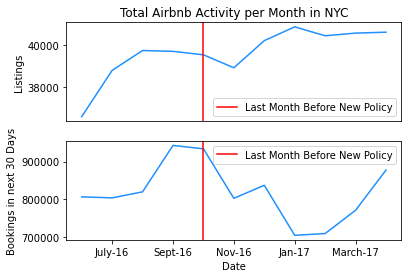

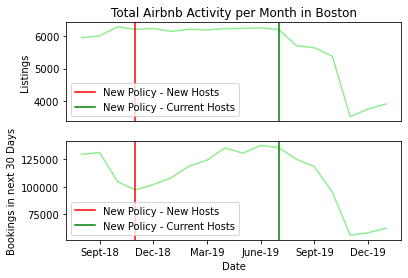

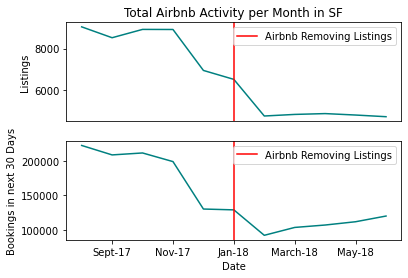

In [48]:
# Create Charts/Summary Stats
nyc_listings["#_booked_30"] = nyc_listings["availability_30"].apply(lambda x: 30-x)
boston_listings["#_booked_30"] = boston_listings["availability_30"].apply(lambda x: 30-x)
sf_listings["#_booked_30"] = sf_listings["availability_30"].apply(lambda x: 30-x)


#Begin by Showing Listings and bookings
nyc_count = nyc_listings.groupby("date").agg({"id": "count", "#_booked_30": "sum"})
boston_count = boston_listings.groupby("date").agg({"id": "count", "#_booked_30": "sum"})
sf_count = sf_listings.groupby("date").agg({"id": "count", "#_booked_30": "sum"})

def listings_bookings_chart(count_df, city, date_labels_list, xtick_list, policy_date, vertlabel, color):
    '''
    Creates a chart with subplots for total listings/bookings data for each city
    Inputs:
    count_df: dataframe with total listings/bookings data for city
    city: city of interest
    date_labels_list: list of date labels 
    xtick_list: list of tick marks on x-axis
    policy_date: date policy takes full effect
    color: color of line plot
    '''
    count_df["date"] = count_df.index
    plt.subplot(2, 1, 1)
    ax1 = sns.lineplot(data=count_df,x="date", y="id", color = color)
    plt.ylabel("Listings")
    plt.xlabel("")
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    if city == "Boston":
        plt.axvline("2018-12-13", 0, 100000, color = 'r', label = "New Policy - New Hosts")
        plt.axvline("2019-08-19", 0, 100000, color = 'g', label = "New Policy - Current Hosts")
    else:
        plt.axvline(policy_date, 0, 100000, color = 'r', label = vertlabel)
    plt.legend()
    plt.title("Total Airbnb Activity per Month in " + city)
    
    plt.subplot(2, 1, 2)
    ax2 = sns.lineplot(data=count_df,x="date", y="#_booked_30", color = color)
    plt.xlabel("Date")
    plt.ylabel("Bookings in next 30 Days")
    if city == "Boston":
        plt.axvline("2018-12-13", 0, 100000, color = 'r', label = "New Policy - New Hosts")
        plt.axvline("2019-08-19", 0, 100000, color = 'g', label = "New Policy - Current Hosts")
    else:
        plt.axvline(policy_date, 0, 100000, color = 'r', label = vertlabel)
    plt.legend()
    plt.xticks(ticks = xtick_list, labels = date_labels_list)
    plt.savefig(f"{cwd}{sep}tex{sep}images{sep}" + city +"_total.png")
    plt.show()

# NYC
nyc_date_list = ["July-16", "Sept-16", "Nov-16", "Jan-17", "March-17"]
nyc_tick_list = [1,3,5,7,9]
listings_bookings_chart(nyc_count, "NYC", nyc_date_list, nyc_tick_list, 4, vertlabel = "Last Month Before New Policy", color = 'dodgerblue')

# Boston
boston_date_list = ["Sept-18", "Dec-18", "Mar-19", "June-19", "Sept-19", "Dec-19"]
boston_tick_list = [1, 4, 7, 10, 13, 16]
listings_bookings_chart(boston_count, "Boston", boston_date_list, boston_tick_list, "2019-08-19", vertlabel = "", color = 'lightgreen')

# SF
sf_date_list = ["Sept-17", "Nov-17", "Jan-18", "March-18", "May-18"]
sf_tick_list = [1,3,5,7,9]
listings_bookings_chart(sf_count, "SF", sf_date_list, sf_tick_list, 5, vertlabel = "Airbnb Removing Listings", color = 'teal')


In [68]:
# Summary Stats: 

# #_bookings_30 = total sum/id (bookings per listing)
all_final["#_booked_per_airbnb"] = all_final["#_booked_30"]/all_final["id"]

# Total number of listings in gentrified neighborhoods
all_final["total_gent"] = all_final["gent_flag"]*all_final["id"]


# Collapse down by city/month/year 
summ_stats = all_final.groupby(["city", "month", "year"]).agg({"#_complaints": ["sum", "mean", "max", "min"], "#_booked_30": "sum", "#_booked_per_airbnb": "mean","id": ["sum",\
                                                              "mean", "max", "min"], "room_type_recoded": "sum", "host_multi_listings_flag": "sum","host_is_superhost_recoded": \
                                                              "sum", "total_gent": "sum", "med_hh_income": ["max", "min", "mean"]}).reset_index()

complaints = all_final.groupby(["city", "month", "year", "complaint_type"]).agg({"#_complaints": "sum"}).reset_index()

# format and output charts 
complaints = complaints[complaints["complaint_type"] != "None"]
complaints.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}complaints.tex",index = False)

for col in summ_stats.columns:
    if col == ("#_complaints","mean") or col == ("#_booked_per_airbnb", "mean") or col == ("id", "mean") \
    or col == ("med_hh_income", "mean"):
        summ_stats[col] = summ_stats[col].apply(lambda x: round(x, 3))
        
# Change Room Type, Host is Superhost, # of hosts w second home, and Gentrification from Total #s of listing to % of all listings
summ_stats["room_type_recoded"] = round(summ_stats[("room_type_recoded", "sum")]*100/summ_stats[("id", "sum")],1)
summ_stats["host_is_superhost_recoded"] = round(summ_stats[("host_is_superhost_recoded", "sum")]*100/summ_stats[("id", "sum")],1)
summ_stats["total_gent"] = round(summ_stats[("total_gent", "sum")]*100/summ_stats[("id", "sum")],1)
summ_stats["host_multi_listings_flag"] = round(summ_stats[("host_multi_listings_flag", "sum")]*100/summ_stats[("id", "sum")],1)


summ_stats.sort_values(by=['city','year',"month"], inplace=True)
    
month_recode_dict = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", \
                    9: "September", 10: "October", 11: "November", 12: "December"}
summ_stats["month"] = summ_stats["month"].map(month_recode_dict)
summ_stats = summ_stats.rename(columns = {"month": "Month", "year": "Year", "#_complaints": "Number of Complaints", "#_booked_30": "Total Bookings in 30 Days", \
                            "#_booked_per_airbnb": "Number of Bookings in 30 Days per Airbnb", "id": "Total Listings", \
                            "room_type_recoded": "% of Listings that are Entire Home", "host_multi_listings_flag": "% of Hosts with more than 1 Listing" , "host_is_superhost_recoded": "% of Listings with Superhost", 
                            "total_gent": "% of Airbnbs in Gentrifying Neighborhoods", "med_hh_income": "Neighborhood Median HH Income"})

# Divide up by city and in half 
boston_part1 = summ_stats[summ_stats["city"] == "Boston"][["Month", "Year", "Number of Complaints", "Total Bookings in 30 Days"]]
boston_part2 = summ_stats[summ_stats["city"] == "Boston"][["Month", "Year","Number of Bookings in 30 Days per Airbnb", "Total Listings"]]
boston_control_part1 = summ_stats[summ_stats["city"] == "Boston"][["Month", "Year", "% of Listings that are Entire Home", "% of Hosts with more than 1 Listing", "% of Listings with Superhost"]] 
boston_control_part2 = summ_stats[summ_stats["city"] == "Boston"][["Month", "Year","Neighborhood Median HH Income"]]
nyc_part1 = summ_stats[summ_stats["city"] == "NYC"][["Month", "Year", "Number of Complaints", "Total Bookings in 30 Days"]]
nyc_part2 = summ_stats[summ_stats["city"] == "NYC"][["Month", "Year","Number of Bookings in 30 Days per Airbnb", "Total Listings"]]
nyc_control_part1 = summ_stats[summ_stats["city"] == "NYC"][["Month", "Year","% of Listings that are Entire Home", "% of Hosts with more than 1 Listing", "% of Listings with Superhost"]] 
nyc_control_part2 = summ_stats[summ_stats["city"] == "NYC"][["Month", "Year", "% of Airbnbs in Gentrifying Neighborhoods", "Neighborhood Median HH Income"]]
sf_part1 = summ_stats[summ_stats["city"] == "SF"][["Month", "Year","Number of Complaints", "Total Bookings in 30 Days"]]
sf_part2 = summ_stats[summ_stats["city"] == "SF"][["Month", "Year","Number of Bookings in 30 Days per Airbnb", "Total Listings"]]
sf_control_part1 = summ_stats[summ_stats["city"] == "SF"][["Month", "Year", "% of Listings that are Entire Home", "% of Hosts with more than 1 Listing", "% of Listings with Superhost"]] 
sf_control_part2 = summ_stats[summ_stats["city"] == "SF"][["Month", "Year","% of Airbnbs in Gentrifying Neighborhoods", "Neighborhood Median HH Income"]]

# Output to LaTeX
boston_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}boston_part1.tex", index = False)
boston_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}boston_part2.tex", index = False)
boston_control_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}boston_control_part1.tex", index = False)
boston_control_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}boston_control_part2.tex", index = False)
nyc_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}nyc_part1.tex", index = False)
nyc_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}nyc_part2.tex", index = False)
nyc_control_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}nyc_control_part1.tex", index = False)
nyc_control_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}nyc_control_part2.tex", index = False)
sf_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}sf_part1.tex", index = False)
sf_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}sf_part2.tex", index = False)
sf_control_part1.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}sf_control_part1.tex", index = False)
sf_control_part2.to_latex(f"{cwd}{sep}tex{sep}tables{sep}summ_stats{sep}sf_control_part2.tex", index = False)



In [50]:
import scipy.stats as stats
# Correlations and IV
# Correlations btwn # complaints and listings/bookings
correlation_table = all_final[["complaint_type","#_complaints", "id", "#_booked_30"]]

def assign_pstar(p):
    # Assign the appropiate number of stars to a p-value
    if p< 0.05:
        pstar = "*"
    elif p< 0.01:
        pstar = "**"
    elif p < 0.001:
        pstar = "***"
    else:
        pstar = ""
    return pstar

# Create function that creates tables for correlations
def correlations(index_title, complaint_type = "all"):
    if complaint_type == "all":
        table = correlation_table
    else:
        table = correlation_table[correlation_table["complaint_type"] == complaint_type]
    r1, p1 = stats.pearsonr(table["#_complaints"], table["id"])
    r2, p2 = stats.pearsonr(table["#_complaints"], table["#_booked_30"])
    p1_star = assign_pstar(p1)
    p2_star = assign_pstar(p2)
    corr_data = {'Total Number of Listings': str(round(r1,2))+p1_star, 'Bookings in next 30 Days': str(round(r2,2))+p2_star}
    corr_df = pd.DataFrame(corr_data, index = [index_title])
    return corr_df

# Run and output correlations to latex
all_table = correlations(index_title = "Number of Total Complaints")
noise_table = correlations(index_title = "Number of Noise Complaints",complaint_type ="Noise")  
infest_table = correlations(index_title = "Number of Infestations Complaints",complaint_type ="Infestation")  
parking_table = correlations(index_title = "Number of Parking Complaints",complaint_type ="Parking")  

correlations_table = all_table.append(noise_table.append(infest_table.append(parking_table)))
correlations_table.to_latex(f"{cwd}{sep}tex{sep}tables{sep}correlations.tex")

In [78]:
# IV reg prep
# gen a var that is unique for every lat/long combination which will serve as our cluster in clustered SEs
# to do so, first collapse by latitude/longitude
gen_cluster_df = all_final.groupby(["latitude", "longitude"]).agg({"id": "count"}).reset_index()
# create cluster variable equal to row/index number
gen_cluster_df["cluster"] = [row+1 for row in range(gen_cluster_df.shape[0])]
gen_cluster_df.drop(labels="id", axis=1, inplace=True)

# Merge back into main data set 
all_final = all_final.merge(gen_cluster_df, on = ["latitude", "longitude"])

# #Rename #_complaints and #_booked_30 as it doesn't output to csv correctly
# all_final.rename(columns = {"#_complaints": "num_complaints", "#_booked_30":"num_booked_30"}, inplace = True)

# # output to csv for R

# all_final.to_csv(f"{cwd}{sep}stats_summative{sep}data{sep}all_final.csv")


In [73]:
# Num of Obs
print("Boston # Obs: " + str(boston_final.shape[0]))
print("NYC # Obs: " + str(nyc_final.shape[0]))
print("SF # Obs: " + str(sf_final.shape[0]))

Boston # Obs: 47991
NYC # Obs: 245771
SF # Obs: 44841


In [85]:
print("Boston Clusters: " + str(len(all_final["cluster"][all_final["city"] == "Boston"].unique())))
print("NYC Clusters: " + str(len(all_final["cluster"][all_final["city"] == "NYC"].unique())))
print("SF Clusters: " + str(len(all_final["cluster"][all_final["city"] == "SF"].unique())))

Boston Clusters: 4298
NYC Clusters: 42521
SF Clusters: 6806
